<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/week07_part2_cGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning How to Implement Pix2pix cGAN

In this tutorial we will explain and implement the [Image-to-image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004) paper step by step. 

Pix2pix is a method presented in the Computer Vision and Pattern Recognition (CVPR) conference in 2017. Authors introduced a conditional GAN (cGAN) to transform images from one domain to another. The main difference with classical GANs is that cGANs are conditioned to some input data, in our case, we condition the GAN with images. See some examples from the paper of image domain transformation:





> 




![texto alternativo](https://i.ibb.co/Mf08787/examples.jpg)


Authors in the paper investigated conditional adversarial networks as a general-purpose solution to image-to-image translation problems. They exposed in their work that those networks did not only learn the mapping from an input image to an output image but also learned a loss function to train this mapping. Therefore, they do not longer need to hand-engineer mapping functions, and still achieve reasonable results without hand-engineering their loss functions either.

# Conditional GANs (cGANs)

Conditional GANs where introduced in 2014, [link to the paper](https://arxiv.org/abs/1411.1784). They presented a variant of classical GAN architectures where the input and output are conditioned on some extra information. 

Conditional GANs added additional information to the input of the generator and, in addition, the discriminator.

Imagine that we have two different domains, A and B, and we want to go from one to the other. Let's use the case of night/day transformation. We want to feed a network with night images and transform them into day condition illumination images. In classical GANs, we used these two domains for training the architecture, but here, in addition, we can use the relationship between images from domain A and domain B. As in cGANS we also have paired images, in our example, paired night/day images, when we transform an image from A to B, we have its equivalent image in the other domain. In other words, we can use this relationship to condition a GAN to output a specific image in domain B, when using as an input the corresponding image from domain A. 

Next example from the paper shows images from domain A (real word), and domain B (edges): 

<a href="https://imgbb.com/"><img src="https://i.ibb.co/rF2w5Tt/Screenshot-from-2019-02-25-15-47-18.png" alt="Screenshot-from-2019-02-25-15-47-18" border="0"></a>

The input of the generator, G, is no longer a single random vector, but an input image from domain A. Similarly, we feed the discriminator, D, with paired images, generated/edges and real/edges. Therefore, the information that can use the network to seek convergence is much wider than in classical GANs. As in regular GANs, the discriminator learns to classify between fake (synthesized by the generator) and real {edge, photo} tuples. The generator learns to fool the discriminator. Unlike an unconditional GAN, both the generator and discriminator observe the input edge map.

In other words, the generator is trained to produce outputs that cannot be distinguished from “real” images by an adversarially trained discriminator which is trained to do as well as possible at detecting the generator’s “fakes”.

# Coloring Black and White Images

The aim of the tutorial is to build the pix2pix code for coloring images. We will use CIFAR10 dataset to perform the experiment, however, you could try to use your own dataset. For instance, check [this repo](https://github.com/kvfrans/deepcolor) which shows how to color manga-style images. 

The idea is quite intuitive, first of all, we will transform images to greyscale color space and train a generator that will transform them back to RGB images. As in classical GANs, we use the discriminator to differentiate between *Fake* and *Real* images. 

Thus, we have A and B domain, color and BW, respectively.



## Dataset Generator

When training a cGAN, or any regular GAN architecture, we need to train independently the generator and discriminator networks. As seen, training is a min-max game between the two nets.

Firstly, we aim to train the generator to be able to fool the discriminator, while in the next iteration, we will train the discriminator to be able to distinguish between the generated (fake) images and the real ones. 

We are going to switch the training between networks in every step. Instead of training per a whole epoch as has been seen in the previous tutorials, we will generate batches and train first the discriminator and then switch to train the generator. 

In order to accomplish that, we need to use the module provided by Keras *model.train_on_batch()* and code our own training loop. In this case, we can not rely on Keras to handle the dataset as done previously, but instead, we need to create a dataset generator to feed with batches our training loop. 

We define then our class *DataLoader()*:

In [1]:
import keras
from keras.datasets import cifar10, cifar100
from keras.layers import Lambda, Input
from keras.models import Model
from keras.backend import tf as ktf
import numpy as np
import matplotlib.pyplot as plt
import datetime

class DataLoader():
  def __init__(self, dataset_name, img_res=(32, 32)):
    self.dataset_name = dataset_name
    self.img_res = img_res
    self.load_dataset()
  
  def _start_epoch(self):  
  
    random_idx = np.random.permutation(len(self.im_A_train))
    self.im_A_train_epoch = self.im_A_train[random_idx]
    
  def load_dataset(self):
    
    if self.dataset_name == 'CIFAR10':
      (im_A_train, y_train), (im_A_test, y_test) = cifar10.load_data()
    elif self.dataset_name == 'CIFAR100':
      (im_A_train, y_train), (im_A_test, y_test) = cifar100.load_data()
    else:
      raise Exception('Please, select a valid dataset')
      
    self.im_A_train = im_A_train.astype('float32')
    self.im_A_test = im_A_test.astype('float32')
    self.im_A_train /= 255.
    self.im_A_test /= 255.
    
  def get_dataset_shape(self, is_training=True):
    
    if is_training:
      return self.im_A_train.shape
    else:
      return self.im_A_test.shape
    
  def get_num_batches(self, batch_size):
    return int(self.im_A_train.shape[0] / batch_size)
  
  def set_image_transformations(self, convert_to_bw):
    
    self.convert_to_bw = convert_to_bw
  
  def load_batch(self, batch_size=1, is_training=True):
        
    if is_training:
      
      self._start_epoch()   
      num_batches = int((self.im_A_train).shape[0] / batch_size)
      
    else:
      num_batches = int((self.im_A_test).shape[0] / batch_size)
    
    for idx_batch in range(num_batches):
      
      init = idx_batch * batch_size
      end = (idx_batch + 1) * batch_size
      
      if is_training:
        batch = self.im_A_train_epoch[init:end]
      else:
        batch = self.im_A_test[init:end]
 
      batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
            
      # Convert to B&W
      batch_bw = self.convert_to_bw.predict(batch)
      
      yield [batch, batch_bw]
      
  def get_random_batch(self, batch_size=1, is_training=True):
    
    if is_training:
      random_idx = np.random.permutation(len(self.im_A_train))
      batch = self.im_A_train[random_idx[0:batch_size]]
    else:
      random_idx = np.random.permutation(len(self.im_A_test))
      batch = self.im_A_test[random_idx[0:batch_size]]

    batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
        
    # Convert to B&W
    batch_bw = self.convert_to_bw.predict(batch)
      
    return [batch, batch_bw]

Using TensorFlow backend.


*DataLoader* class needs only the name of the dataset to load. Now, it is able to load CIFAR10 and CIFAR100. Let's see what some of *DataLoader*'s methods do:


*   *_start_epoch()* is a private method. It shuffles the dataset every time that *load_batch()* is called. 
*   *load_dataset()* loads the dataset into *DataLoader* object. If you want to use your own dataset, you should include its loading method here. If it does not fit in memory, you should load the paths of the images in *load_dataset()* and include a reading method inside *load_batch()*.
*  *load_batch()* creates a python generator. In each iteration, it will return a batch from the shuffled dataset.

Let's now create the dataset class. 



In [2]:
# Load the data, shuffled and split between train and test sets
dataset_loader = DataLoader(dataset_name = 'CIFAR10')

training_shape = dataset_loader.get_dataset_shape()
test_shape = dataset_loader.get_dataset_shape(is_training=False)

print('Shape of Training Images: {}'.format(training_shape))
print('Shape of Test Images: {}'.format(test_shape))

170500096/170498071 [==============================] - 26s 0us/step
Shape of Training Images: (50000, 32, 32, 3)
Shape of Test Images: (10000, 32, 32, 3)


## Defining the Domains

As explained above, we will go from B&W to color images. We have loaded CIFAR10 dataset, which is a colored dataset, therefore, we need to define a method to decolor them.

In [0]:
# Convert to greyscale color space
inp = Input(shape=(None, None, 3))
out = Lambda(lambda image: ktf.image.rgb_to_grayscale(image))(inp)

transform_bw = Model(inputs=inp, outputs=out)

# Set predefined transformation in DataLoader Class
dataset_loader.set_image_transformations(transform_bw)

Thus, * transform_bw* will transform images from domain A to images from domain B. We set the defined models into our dataset class, which will transform the images before returning them to us. 

We have defined our task, the method, and the dataset. We can visualize images from both domains before starting to code our cGAN. 

Rerun the following code to visualize different examples:

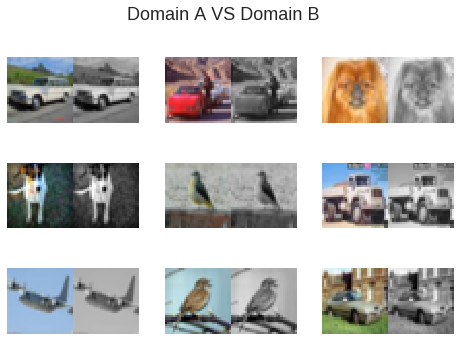

In [4]:
# Load random batch from dataset
random_batch = dataset_loader.get_random_batch(batch_size=9)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 3, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Domain A VS Domain B', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

## Generator Model
For many image translation problems, there is a great deal of low-level information shared between the input and output, and it would be desirable to shuttle this information directly across the net. For example, in the case of image colorization, the input and output share the location of prominent edges. To give the generator a means to circumvent the bottleneck for information like this, we use an architecture with skip connections, following the general shape of already presented UNet.

The generator presented in this tutorial is a simpler version of the one in the paper since we are using low-resolution images (32x32). You can find more complex/deeper versions of UNet in previous tutorials. 

In Pix2pix, authors found beneficial to mix the GAN objective with a more traditional loss, such as L1 between the generated image and the real one. The discriminator’s job remains unchanged, but the generator is tasked to not only fool the discriminator but also to be near the ground truth output in a L1 sense.

Another substantial difference with the cGAN model and previous GANs is that authors only provide noise in form of dropout, while in classical GANs a Gaussian noise was the input of the generator. 

First, we import Keras libraries and then, we are ready to define our cGAN generator model.

In [0]:
from keras.layers import Dropout, merge, concatenate, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Reshape, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

In [0]:
def build_generator(im_shape):
  
  img_B = Input(shape=(im_shape[0], im_shape[1], 1))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(img_B)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = img_B, outputs = conv10, name='generator')
  
  return model

## PatchGAN: Discriminator

In the original paper, authors proposed a discriminator that acts only on local image patches. Their cGAN discriminator only model high-frequency structures, meanwhile, they rely on the L1 generation term to force low-frequency correctness. Therefore, they designed a discriminator architecture that only penalizes structure at the scale of patches. 

Nevertheless, we use a discriminator that acts in the whole image. We are training our architecture with already low-resolution images (32x32), while in original paper they used 256x256 images. 

Let's define the discriminator:

In [0]:
def build_discriminator(im_shape):
  
  img_A = Input(shape=(im_shape[0], im_shape[1], 3))
  img_B = Input(shape=(im_shape[0], im_shape[1], 1))

  combined_imgs = concatenate([img_A, img_B], axis=-1)
    
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(combined_imgs)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)

  disc_layer = Conv2D(128, kernel_size=(5, 5), strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Flatten()(disc_layer)
  disc_layer = Dense(1024)(disc_layer)

  prob = Dense(1, name="disc_dense")(disc_layer)

  discriminator = Model(inputs=[img_A, img_B], outputs=[prob], name='discriminator')
  
  return discriminator


## Training Loop

We arrive to the tricky part of the tutorial, where we need to define the training loop of the cGAN model. 

First, we need to define the optimizers, inputs, outputs and losses for each one of the networks. Let's go line by line:

In [8]:
# Define optimizers for each network.
# Note that if the discriminator is able to differentiate between samples, 
# the generator will be not able to learn. They must learn at the same time.
# Setting the learning rates or learning steps is always tricky.
optimizer_g = Adam(0.0002, 0.5)
optimizer_d = Adam(0.00002, 0.5)

# Input size
im_shape = (32, 32)

# Build and compile the discriminator
discriminator = build_discriminator(im_shape)
discriminator.compile(loss='mse', optimizer=optimizer_d, metrics=['accuracy'])

# Build the generator
generator = build_generator(im_shape)

# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 1))

# By conditioning on B generate a fake version of A.
# Remember, images in B are the B&W version of images in A
fake_A = generator(img_B)

# For the combined model we will only train the generator, thus, we freeze the
# discriminator model when optimizing G.
# We are backpropagating the discriminator's error
# into the generator in order to create fake images that are unrecognizable by D
discriminator.trainable = False

# Discriminators determines if a conditioned pair has been generated or is real
valid = discriminator([fake_A, img_B])

# Minimize discriminator error (only updating generator's weights) and 
# the L1 loss between real and fake images.
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer_g)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


We have created the models and compile them. In addition, before starting the training loop, we define an auxiliary function that will allow us to print images during training to have an idea of how well the generator is coloring the images:

In [0]:
def showColoredIms(imB, fake_imA, real_imA):
  
  plt.subplot(131)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('Domain B', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(fake_imA[0], 0, 1)) 
  plt.title('Fake A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

We provided pretrained weights so you can resume training. These weights were obtained training for close to 20 epochs, results could be improved with longer training. However, just a few epochs also mean a few hours, GAN training is characterized for being long. In our case, a single epoch takes around 50 minutes.

Run the code without loading the weights to see how colored images look at the beginning, with just a few iterations. Afterward, load the weights so you can see how images look much better after 5 epochs, and how G and D losses have decreased. Finally, if you wish, you can play with the number of epochs, hyperparameters, batch size, or even, architecture to improve results. 

In [18]:
# Load weights from a previous session
# Upload weights to Colab by using the File tab

# !wget -O weights.zip https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
# !unzip -q ./weights.zip
# !rm ./weights.zip

# generator.set_weights(keras.models.load_model('./weights/generator.h5').get_weights())
# discriminator.set_weights(keras.models.load_model('./weights/discriminator.h5').get_weights())

--2019-03-01 17:53:08--  https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.24.197, 107.152.25.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip [following]
--2019-03-01 17:53:08--  https://imperialcollegelondon.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip [following]
--2019-03-01 17:53:08--  https://imperialcollegelondon.app.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Resolving imperialcollegelondon.app.box.com (imperialcolleg

Now, we have everything ready to start training our cGAN model. As explained, we need to define our training loop since we want to train the architectures per batches. See the comments to understand what is happening in each line of code.

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


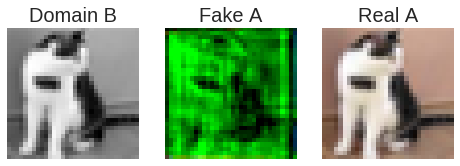

[Epoch 0/1] [Batch 0/390] [D loss: 0.709774, acc:  39%] [G loss: 71.863312] elapsed_time: 0:00:22.055539  remaining_time: 2:22:59.604671
. . . .


In [10]:
num_epochs = 1
batch_size = 128
n_batches = dataset_loader.get_num_batches(batch_size)

# Adversarial loss ground truths. 
# They are used as labels for the discriminator loss.
valid = np.ones((batch_size,))
fake = np.zeros((batch_size,))
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []
  d_avg_loss = []
  d_avg_acc = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
      
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Condition on B and generate a translated (fake) version of A.
    # It will try to color images from B to be as similiar as possible 
    # to their correspoding pairs from A.
    fake_A = generator.predict(imgs_B)      

    # Train the discriminator (original images = real / generated = Fake)
    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_avg_loss.append(d_loss[0])
    d_avg_acc.append(d_loss[1])
    
    # -----------------
    #  Train Generator
    # -----------------

    # Train the generators
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
    g_avg_loss.append(g_loss[0])
    
    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      

    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(d_avg_loss), 100*np.mean(d_avg_acc), np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator.save('generator.h5') 
  discriminator.save('discriminator.h5')

If desired, you can download the weights for resuming future trainings. 

In [0]:
from  google.colab  import files

# Download the weights in your PC
# files.download('generator.h5') 
# files.download('discriminator.h5')

# Coloring Test Images

We have trained our cGAN, and we are ready to visualize how the network colors test images. 

Rerun the following code for visualizing more examples:

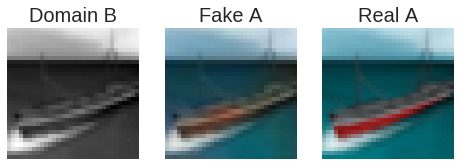

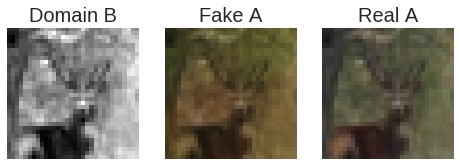

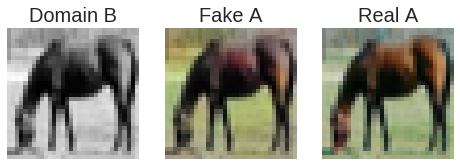

In [17]:
# Load random batch from dataset

for i in range(3):
  [im_A_real, im_B_test] = dataset_loader.get_random_batch(batch_size=1, is_training=False)

  im_A_fake = generator.predict(im_B_test)

  showColoredIms(im_B_test, im_A_fake, im_A_real)

We have shown a simplified version of Pix2pix method. Training GANs is a hard task, and there are many things that could be added to improve results. For instance, [this repo](https://github.com/soumith/ganhacks) shows common tricks to improve GAN performance.  Do not focus much on this one though, you can find many other repositories or blogs with similar methods to improve GANs. 

Now it is your turn, try to get better results.